# <font color='blue'> **Data Sprint HDB Resale Prices** </font>

### Ameer, Benjamin, Leonard, Wei Yu.

---

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from scipy.stats import iqr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import geopandas as gpd
import re
import streamlit as st
import joblib


%matplotlib inline

In [2]:
hdb = pd.read_csv('./datasets/train.csv')

hdb.head()

/var/folders/bv/9kp7wlwx1n94x819spyh3pzc0000gn/T/ipykernel_5856/3995983073.py:1: DtypeWarning: Columns (42) have mixed types. Specify dtype option on import or set low_memory=False.
  hdb = pd.read_csv('./datasets/train.csv')


,id,Tranc_YearMonth,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,...,vacancy,pri_sch_affiliation,pri_sch_latitude,pri_sch_longitude,sec_sch_nearest_dist,sec_sch_name,cutoff_point,affiliation,sec_sch_latitude,sec_sch_longitude
0,88471,2016-05,KALLANG/WHAMPOA,4 ROOM,3B,UPP BOON KENG RD,10 TO 12,90.0,Model A,2006,...,78,1,1.317659,103.882504,1138.633422,Geylang Methodist School,224,0,1.317659,103.882504
1,122598,2012-07,BISHAN,5 ROOM,153,BISHAN ST 13,07 TO 09,130.0,Improved,1987,...,45,1,1.349783,103.854529,447.894399,Kuo Chuan Presbyterian Secondary School,232,0,1.350110,103.854892
2,170897,2013-07,BUKIT BATOK,EXECUTIVE,289B,BT BATOK ST 25,13 TO 15,144.0,Apartment,1997,...,39,0,1.345245,103.756265,180.074558,Yusof Ishak Secondary School,188,0,1.342334,103.760013
3,86070,2012-04,BISHAN,4 ROOM,232,BISHAN ST 22,01 TO 05,103.0,Model A,1992,...,20,1,1.354789,103.844934,389.515528,Catholic High School,253,1,1.354789,103.844934
4,153632,2017-12,YISHUN,4 ROOM,876,YISHUN ST 81,01 TO 03,83.0,Simplified,1987,...,74,0,1.416280,103.838798,312.025435,Orchid Park Secondary School,208,0,1.414888,103.838335


---

# <font color='blue'> Cleaning:

In [3]:
print(f"{hdb.shape[0]} rows and {hdb.shape[1]} columns")

150634 rows and 78 columns


# 150634 rows. 78 columns

# Checking for duplicates by id column

In [4]:
hdb['id'].value_counts().sort_values(ascending=False)

id
88471     1
52757     1
140756    1
139605    1
164978    1
         ..
140504    1
162877    1
39814     1
147177    1
185947    1
Name: count, Length: 150634, dtype: int64

# Dropping irrelevant columns after inspecting Data dict

In [5]:
hdb = hdb.drop(columns=['block', 'address', 'lower', 'upper', 'mid', 'full_flat_type', 'floor_area_sqft', 'lease_commence_date', 'year_completed', 
                  'postal', 'Mall_Within_500m', 'Mall_Within_1km', 'Mall_Within_2km', 'Hawker_Within_500m', 'Hawker_Within_1km', 
                  'Hawker_Within_2km', 'mrt_name', 'mrt_latitude', 'mrt_longitude', 'bus_stop_name', 'bus_stop_latitude', 'bus_stop_longitude',
                  'pri_sch_name', 'vacancy', 'pri_sch_latitude', 'pri_sch_longitude', 'sec_sch_name', 'affiliation', 'sec_sch_latitude', 
                  'sec_sch_longitude', 'planning_area', 'residential', 'market_hawker'])

# Checking for NAs

In [6]:
hdb.isna().sum().sort_values(ascending=False).head()

Mall_Nearest_Distance    829
id                         0
5room_sold                 0
multigen_sold              0
studio_apartment_sold      0
dtype: int64

# Imputing 829 NAs in Mall_Nearest_Distance

In [7]:
mean_nearest_mall = hdb.groupby('town')['Mall_Nearest_Distance'].mean()

mean_nearest_mall = mean_nearest_mall.reset_index()

In [8]:
hdb = pd.merge(hdb, mean_nearest_mall, how='left', on='town')

In [9]:
hdb.head()

,id,Tranc_YearMonth,town,flat_type,street_name,storey_range,floor_area_sqm,flat_model,resale_price,Tranc_Year,...,hawker_market_stalls,mrt_nearest_distance,bus_interchange,mrt_interchange,bus_stop_nearest_distance,pri_sch_nearest_distance,pri_sch_affiliation,sec_sch_nearest_dist,cutoff_point,Mall_Nearest_Distance_y
0,88471,2016-05,KALLANG/WHAMPOA,4 ROOM,UPP BOON KENG RD,10 TO 12,90.0,Model A,680000.0,2016,...,60,330.083069,0,0,29.427395,1138.633422,1,1138.633422,224,901.945072
1,122598,2012-07,BISHAN,5 ROOM,BISHAN ST 13,07 TO 09,130.0,Improved,665000.0,2012,...,77,903.659703,1,1,58.207761,415.607357,1,447.894399,232,757.967159
2,170897,2013-07,BUKIT BATOK,EXECUTIVE,BT BATOK ST 25,13 TO 15,144.0,Apartment,838000.0,2013,...,95,1334.251197,1,0,214.747860,498.849039,0,180.074558,188,915.499125
3,86070,2012-04,BISHAN,4 ROOM,BISHAN ST 22,01 TO 05,103.0,Model A,550000.0,2012,...,86,907.453484,1,1,43.396521,389.515528,1,389.515528,253,757.967159
4,153632,2017-12,YISHUN,4 ROOM,YISHUN ST 81,01 TO 03,83.0,Simplified,298000.0,2017,...,0,412.343032,0,0,129.422752,401.200584,0,312.025435,208,619.459242


In [10]:
hdb['Mall_Nearest_Distance_x'] = hdb['Mall_Nearest_Distance_x'].fillna(hdb['Mall_Nearest_Distance_y'])

In [11]:
hdb = hdb.drop(columns='Mall_Nearest_Distance_y')

In [12]:
hdb.isnull().sum().sort_values(ascending=False).head()

id                       0
5room_sold               0
multigen_sold            0
studio_apartment_sold    0
1room_rental             0
dtype: int64

# Checking datatypes

In [13]:
hdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150634 entries, 0 to 150633
Data columns (total 45 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         150634 non-null  int64  
 1   Tranc_YearMonth            150634 non-null  object 
 2   town                       150634 non-null  object 
 3   flat_type                  150634 non-null  object 
 4   street_name                150634 non-null  object 
 5   storey_range               150634 non-null  object 
 6   floor_area_sqm             150634 non-null  float64
 7   flat_model                 150634 non-null  object 
 8   resale_price               150634 non-null  float64
 9   Tranc_Year                 150634 non-null  int64  
 10  Tranc_Month                150634 non-null  int64  
 11  mid_storey                 150634 non-null  int64  
 12  price_per_sqft             150634 non-null  float64
 13  hdb_age                    15

In [14]:
hdb['Tranc_YearMonth'] = pd.to_datetime(hdb['Tranc_YearMonth'], infer_datetime_format=True)

/var/folders/bv/9kp7wlwx1n94x819spyh3pzc0000gn/T/ipykernel_5856/4027540773.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  hdb['Tranc_YearMonth'] = pd.to_datetime(hdb['Tranc_YearMonth'], infer_datetime_format=True)


In [15]:
hdb = hdb.astype({'floor_area_sqm':'int'})

In [16]:
# commercial
# multistorey_carpark
# precinct_pavilion

# These 3 columns have 'Y' & 'N' values. We change them to 1's & 0's. 

hdb['commercial'] = hdb['commercial'].map({'Y': 1, 'N' : 0})

hdb['multistorey_carpark'] = hdb['multistorey_carpark'].map({'Y': 1, 'N' : 0})

hdb['precinct_pavilion'] = hdb['precinct_pavilion'].map({'Y': 1, 'N' : 0})

In [17]:
hdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150634 entries, 0 to 150633
Data columns (total 45 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   id                         150634 non-null  int64         
 1   Tranc_YearMonth            150634 non-null  datetime64[ns]
 2   town                       150634 non-null  object        
 3   flat_type                  150634 non-null  object        
 4   street_name                150634 non-null  object        
 5   storey_range               150634 non-null  object        
 6   floor_area_sqm             150634 non-null  int64         
 7   flat_model                 150634 non-null  object        
 8   resale_price               150634 non-null  float64       
 9   Tranc_Year                 150634 non-null  int64         
 10  Tranc_Month                150634 non-null  int64         
 11  mid_storey                 150634 non-null  int64   

# Handling outliers:

In [18]:
qr = []
col_data = hdb.columns[[6, 8, 9, 11, 12, 13, 14, 33, 34, 35, 36, 37, 40, 41, 43]]

for x in col_data:
    col_values = hdb[x]
    iqrc = iqr(col_values)
    lower_threshold = np.quantile(col_values, 0.25) - 1.5 * iqrc
    upper_threshold = np.quantile(col_values, 0.75) + 1.5 * iqrc
    qr.append((x, lower_threshold, upper_threshold))

print(qr)

[('floor_area_sqm', np.float64(19.5), np.float64(167.5)), ('resale_price', np.float64(87500.0), np.float64(779500.0)), ('Tranc_Year', np.float64(2006.5), np.float64(2026.5)), ('mid_storey', np.float64(-4.0), np.float64(20.0)), ('price_per_sqft', np.float64(201.34884637564792), np.float64(637.6804322009804)), ('hdb_age', np.float64(-5.5), np.float64(62.5)), ('max_floor_lvl', np.float64(6.0), np.float64(22.0)), ('Mall_Nearest_Distance_x', np.float64(-322.1303121125), np.float64(1582.0513905875)), ('Hawker_Nearest_Distance', np.float64(-1588.0928485000002), np.float64(3639.1744755)), ('hawker_food_stalls', np.float64(10.0), np.float64(90.0)), ('hawker_market_stalls', np.float64(-148.5), np.float64(247.5)), ('mrt_nearest_distance', np.float64(-317.9355169727911), np.float64(1751.935997825704)), ('bus_stop_nearest_distance', np.float64(-32.39738682939844), np.float64(254.0822865370127)), ('pri_sch_nearest_distance', np.float64(-185.56116819648815), np.float64(914.823716293168)), ('sec_sch_n

In [19]:
for col, lower, upper in qr:
    hdb = hdb[(hdb[col] >= lower) & (hdb[col] <= upper)]

In [20]:
hdb.shape

(103104, 45)

# <font color='blue'> Updated numbers after excluding outliers: **Rows 103104, Columns 45**

# Reading in & merging Mature Estate extra dataset:

from https://dollarbackmortgage.com/blog/mature-or-non-mature-hdb-better/

In [21]:
mature_estates = pd.read_csv('./datasets/mature estates.csv')

mature_estates.head()

,town,Mature Estates,zone
0,ANG MO KIO,1,north
1,BEDOK,1,east
2,BISHAN,1,north
3,BUKIT MERAH,1,south
4,BUKIT TIMAH,1,west


In [22]:
hdb = pd.merge(hdb, mature_estates, how='left', on='town')

In [23]:
hdb.head()

,id,Tranc_YearMonth,town,flat_type,street_name,storey_range,floor_area_sqm,flat_model,resale_price,Tranc_Year,...,mrt_nearest_distance,bus_interchange,mrt_interchange,bus_stop_nearest_distance,pri_sch_nearest_distance,pri_sch_affiliation,sec_sch_nearest_dist,cutoff_point,Mature Estates,zone
0,122598,2012-07-01,BISHAN,5 ROOM,BISHAN ST 13,07 TO 09,130,Improved,665000.0,2012,...,903.659703,1,1,58.207761,415.607357,1,447.894399,232,1.0,north
1,86070,2012-04-01,BISHAN,4 ROOM,BISHAN ST 22,01 TO 05,103,Model A,550000.0,2012,...,907.453484,1,1,43.396521,389.515528,1,389.515528,253,1.0,north
2,26610,2013-01-01,GEYLANG,3 ROOM,ALJUNIED CRES,07 TO 09,65,Improved,335000.0,2013,...,678.291272,0,1,229.680469,594.128568,1,608.838174,224,1.0,east
3,173300,2018-05-01,HOUGANG,5 ROOM,HOUGANG AVE 8,07 TO 09,120,Improved,433000.0,2018,...,1370.648274,0,0,46.567429,331.669318,0,294.826501,224,0.0,east
4,103385,2014-06-01,SENGKANG,5 ROOM,ANCHORVALE RD,10 TO 12,110,Improved,490000.0,2014,...,1054.995148,1,1,89.350913,94.340507,0,458.532781,243,0.0,north


# Inspecting spread/distribution using histograms, value_counts

Identified 2 columns with uneven spread that can't be used. Dropping multistorey_carpark,  precinct_pavilion.

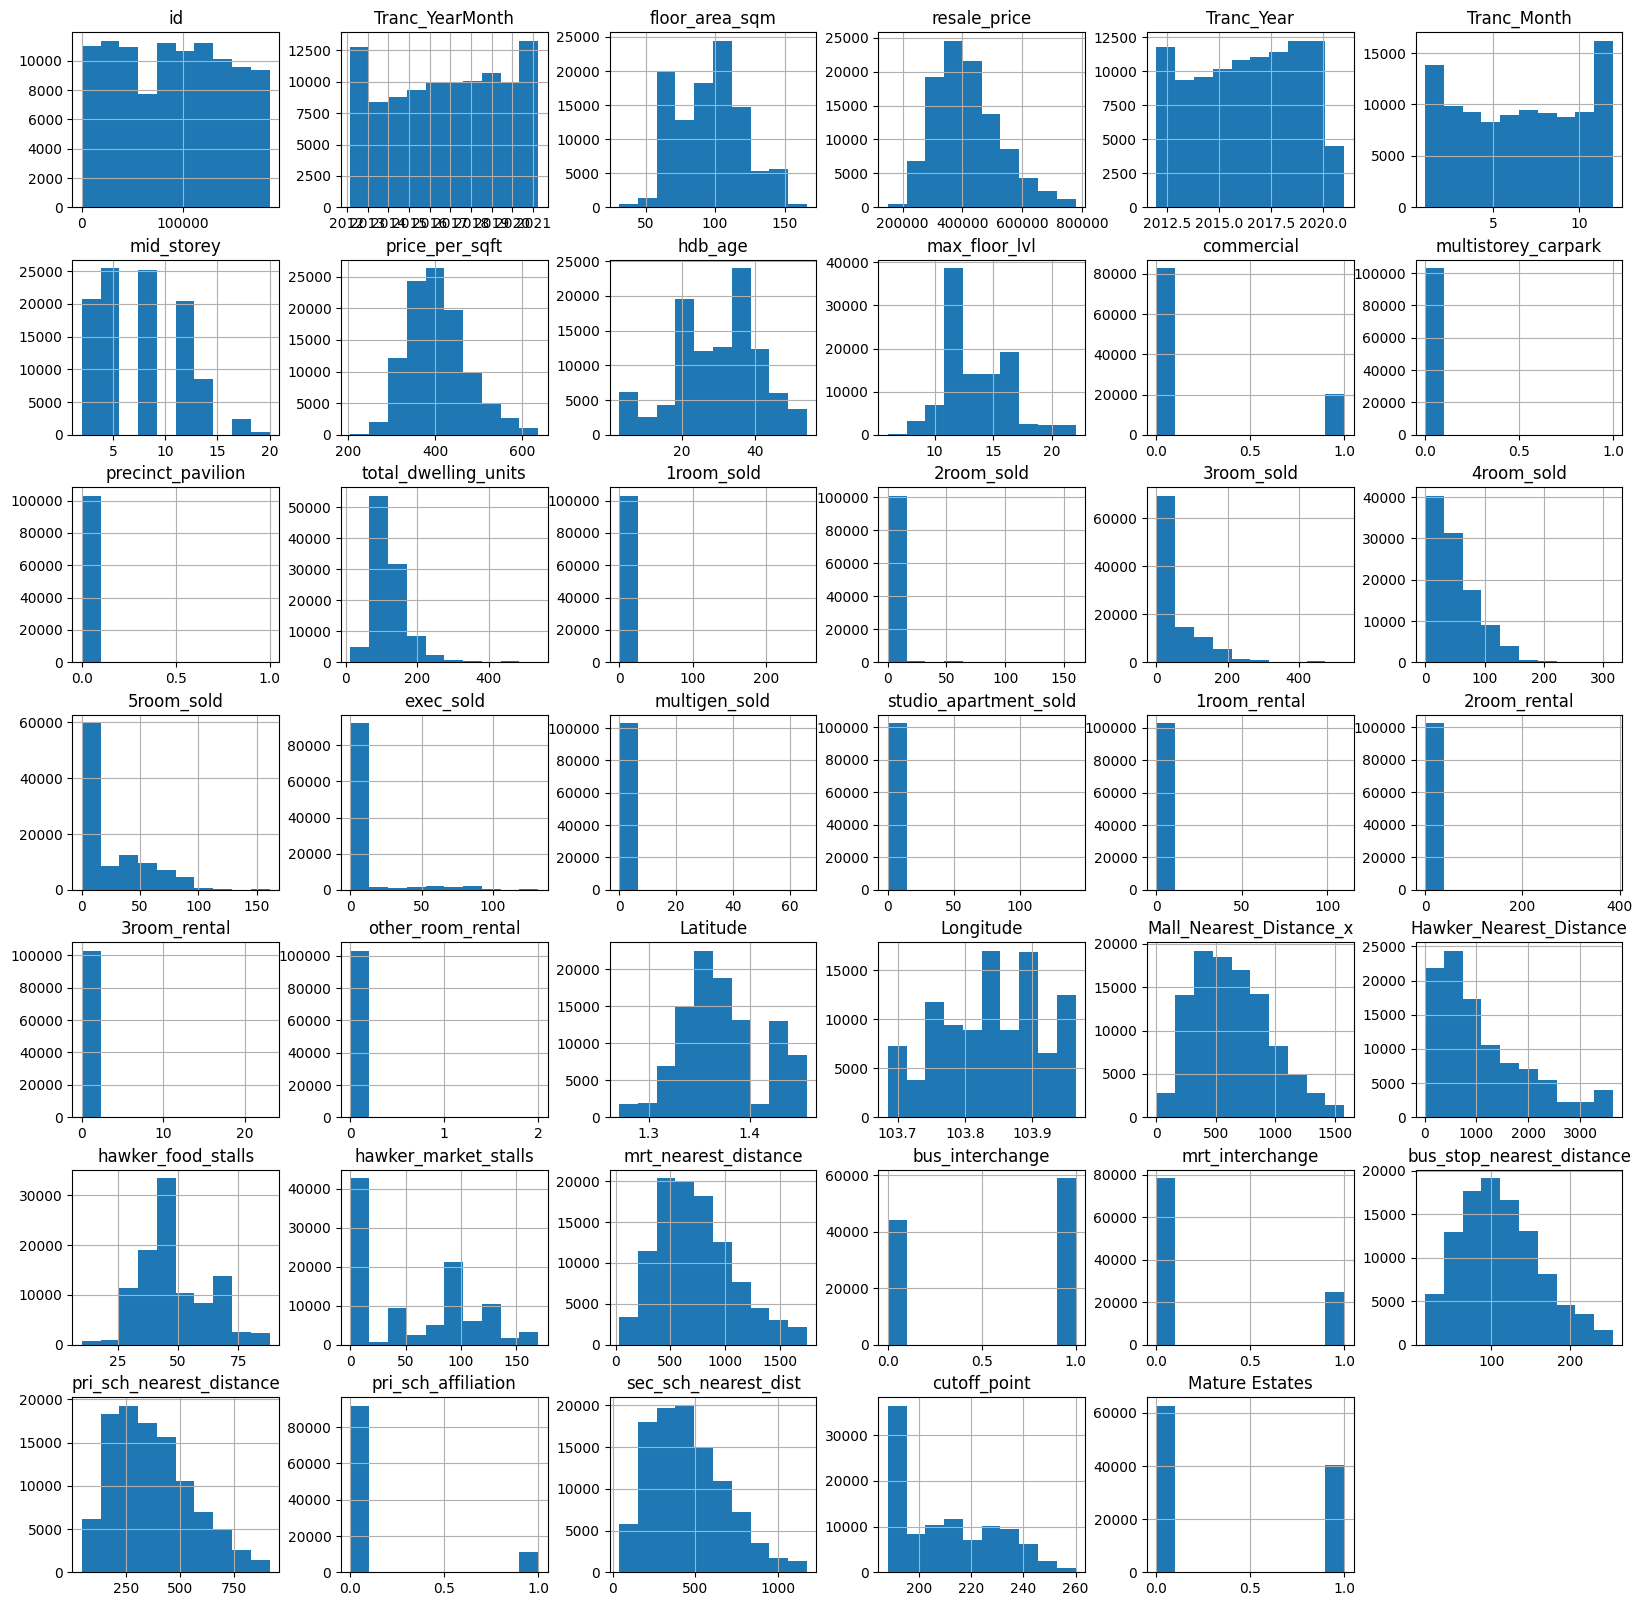

In [24]:
hdb.hist(figsize=(20,20));

In [25]:
hdb['multistorey_carpark'].value_counts()

multistorey_carpark
0    103069
1        35
Name: count, dtype: int64

In [26]:
hdb['precinct_pavilion'].value_counts()

precinct_pavilion
0    103045
1        59
Name: count, dtype: int64

In [27]:
hdb = hdb.drop(columns=['multistorey_carpark', 'precinct_pavilion'])

---

# <font color='blue'> EDA:

# Flat Type Performance
### 15. As an agent, I want to understand the average resale price per flat type (e.g., 3-room, 4-room) in different regions of Singapore, to identify potential sales opportunities.

### 23. As an agent, I want to compare resale prices across different flat types (e.g., Studio, 3-Room, Executive) to guide my sales strategy

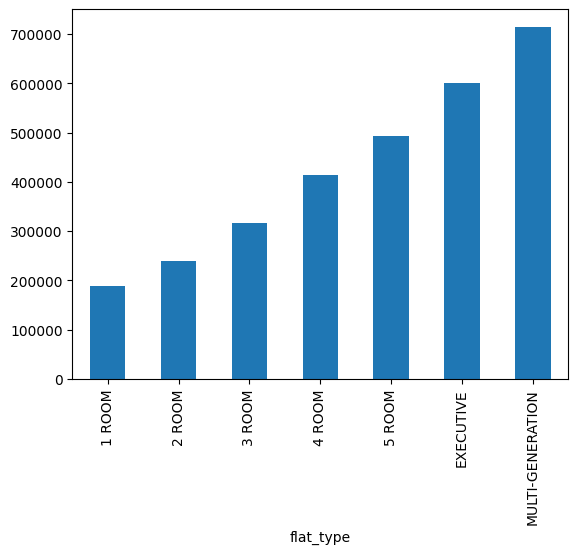

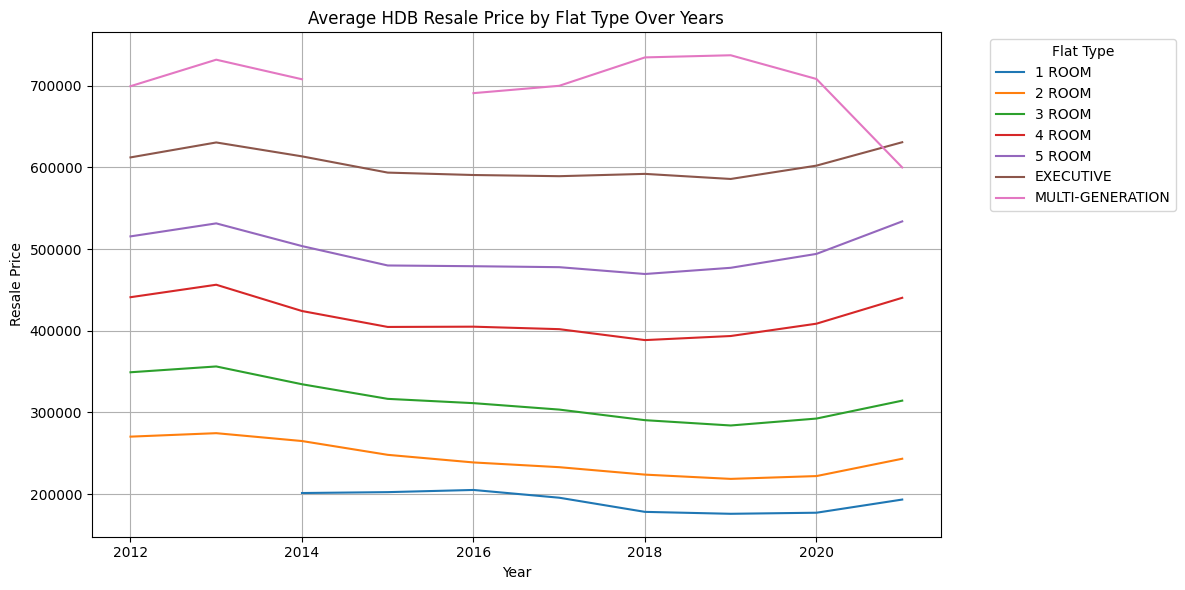

In [28]:
# Average Resale Prices by Flat Types over Time
hdb.groupby('flat_type')['resale_price'].mean().plot(kind = 'bar')

hdb.groupby(['Tranc_Year', 'flat_type'])['resale_price'].mean().unstack()
hdb.groupby(['Tranc_Year', 'flat_type'])['resale_price'].mean().unstack().plot(figsize=(12, 6))
plt.title('Average HDB Resale Price by Flat Type Over Years')
plt.ylabel('Resale Price')
plt.xlabel('Year')
plt.legend(title='Flat Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

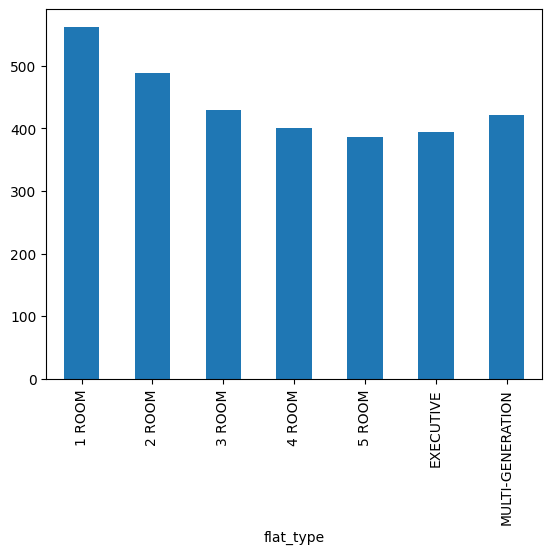

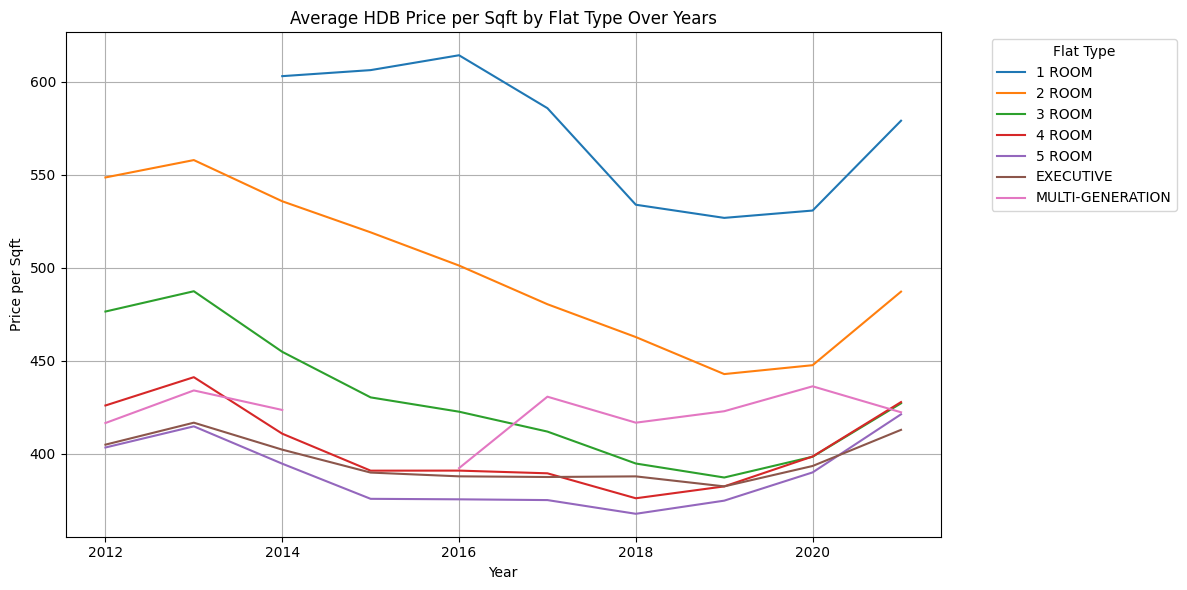

In [29]:
# Average HDB Resale Price per Sqft by Flat Type over Time
hdb.groupby('flat_type')['price_per_sqft'].mean().plot(kind = 'bar')

hdb.groupby(['Tranc_Year', 'flat_type'])['price_per_sqft'].mean().unstack().plot(figsize=(12, 6))
plt.title('Average HDB Price per Sqft by Flat Type Over Years')
plt.ylabel('Price per Sqft')
plt.xlabel('Year')
plt.legend(title='Flat Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Market Movement Over Time

### 19. As an agent, I want to know the average transaction volume and frequency in the HDB resale market, to gauge market liquidity and activity.

This means that on average, around 10310 HDB resale flats are transacted per month in the dataset, with fairly consistent month-to-month activity, indicating a liquid and active secondary market.

### 12. As an agent, I want to better understand HDB resale prices and trends over time, so I can make informed investment decisions.

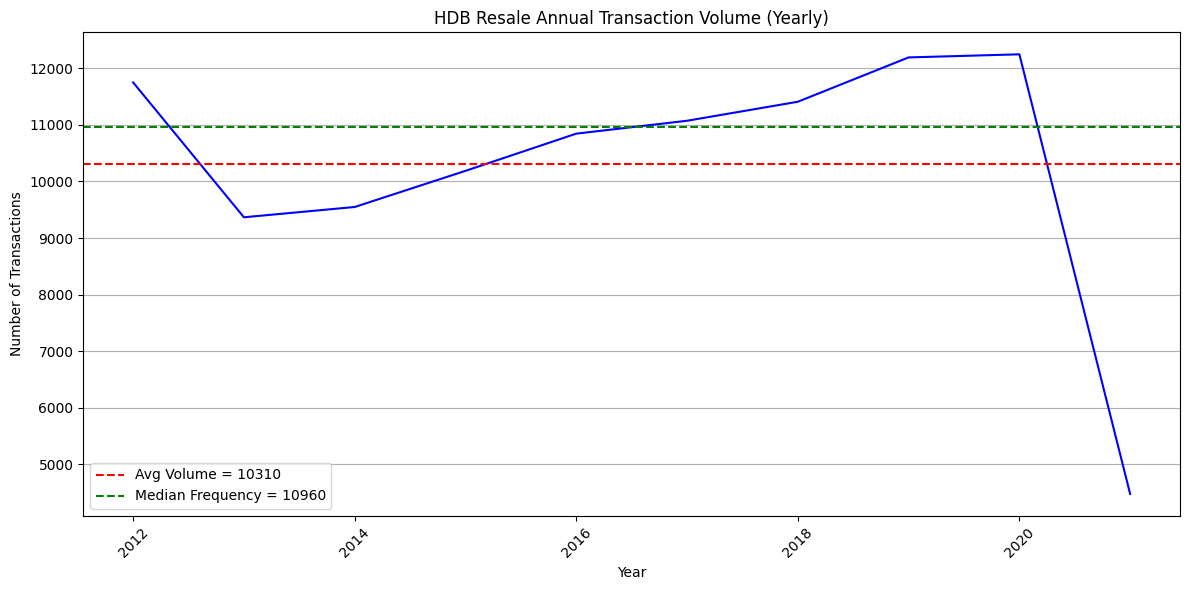

The average transaction volume is 10310.0 and the average transaction frequency is 10960.0


In [ ]:
# QUESTION 19:
# Group by Year and count transactions
yearly_volume = hdb.groupby('Tranc_Year').size()
# Compute average transaction volume and median (typical frequency)
average_yearly_volume = yearly_volume.mean()
median_yearly_frequency = yearly_volume.median() # Median is better at representing a "typical" month when data is uneven or contains outliers.

plt.figure(figsize=(12, 6))
yearly_volume.plot(kind='line', color='blue')
plt.axhline(y=average_yearly_volume, color='red', linestyle='--', label=f'Avg Volume = {average_yearly_volume:.0f}')
plt.axhline(y=median_yearly_frequency, color='green', linestyle='--', label=f'Median Frequency = {median_yearly_frequency:.0f}')
plt.title('HDB Resale Annual Transaction Volume (Yearly)')
plt.xlabel('Year')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()
print(f"The average transaction volume is {average_yearly_volume.round(0)} and the average transaction frequency is {median_yearly_frequency}")

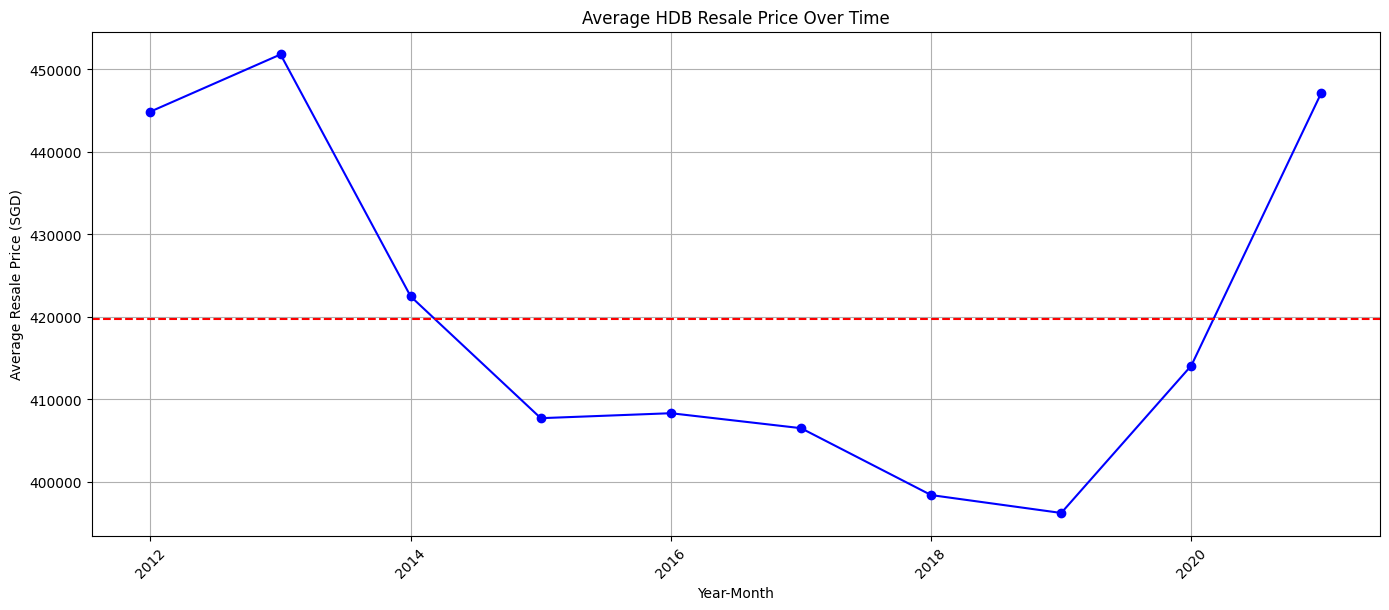

In [31]:
price_trend = hdb.groupby('Tranc_Year')['resale_price'].mean().sort_index()
avg_yearly_transaction = price_trend.mean()

plt.figure(figsize=(14, 6))
price_trend.plot(marker='o', color='blue')
plt.axhline(y=avg_yearly_transaction, color='red', linestyle='--', label=f'Avg Volume = {avg_yearly_transaction:.0f}')
plt.title('Average HDB Resale Price Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Average Resale Price (SGD)')
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

# Average Resale Price by Flat Type & Estate Maturity
Didn't include in slides because not included as a feature

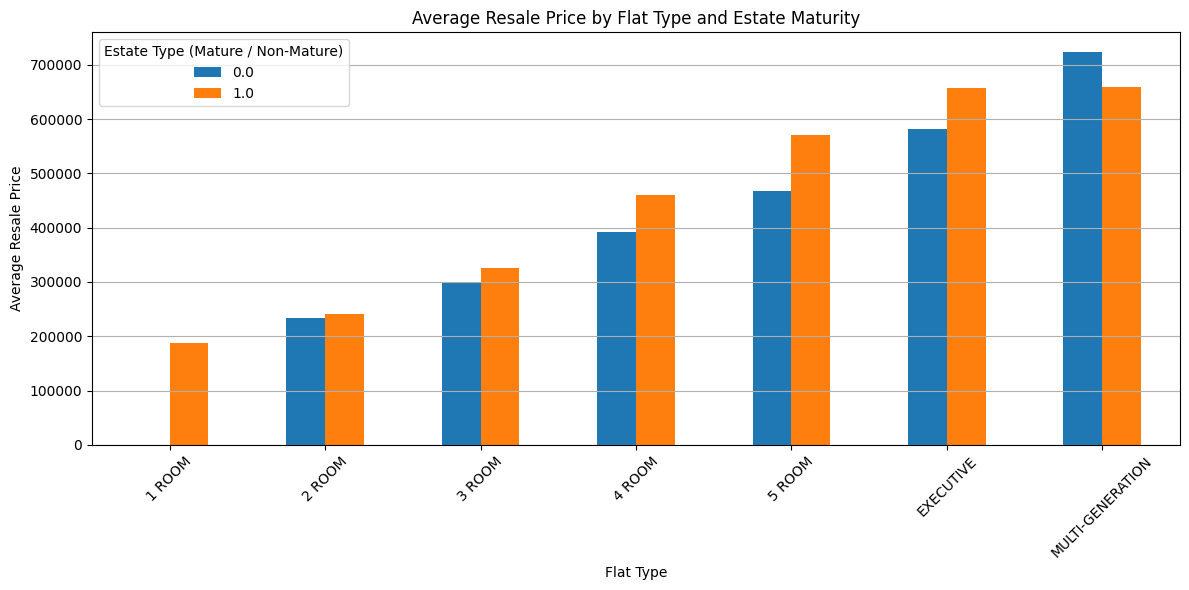

In [32]:
grouped = hdb.groupby(['flat_type', 'Mature Estates'])['resale_price'].mean().unstack()
grouped.plot(kind='bar', figsize=(12, 6))
plt.title('Average Resale Price by Flat Type and Estate Maturity')
plt.ylabel('Average Resale Price')
plt.xlabel('Flat Type')
plt.xticks(rotation=45)
plt.legend(title='Estate Type (Mature / Non-Mature)', loc='upper left')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Location Dynamics
### 14. As an agent, I want to see a map showing the distribution of HDB resale flats across Singapore, to visualize potential sales opportunities.

### 22. As an agent, I want to Identify location-based trends to guide my sales strategy

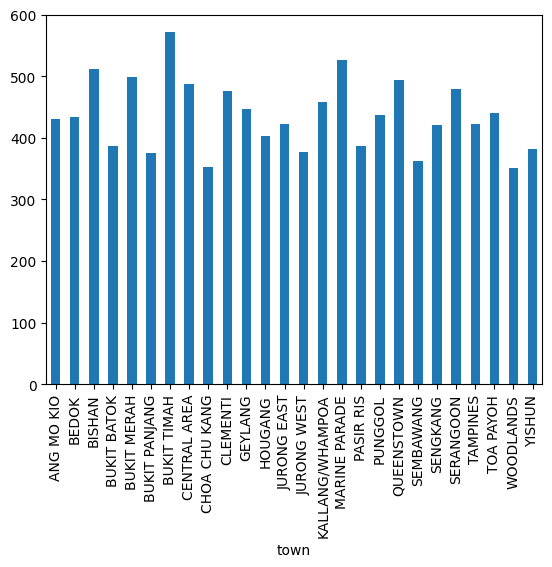

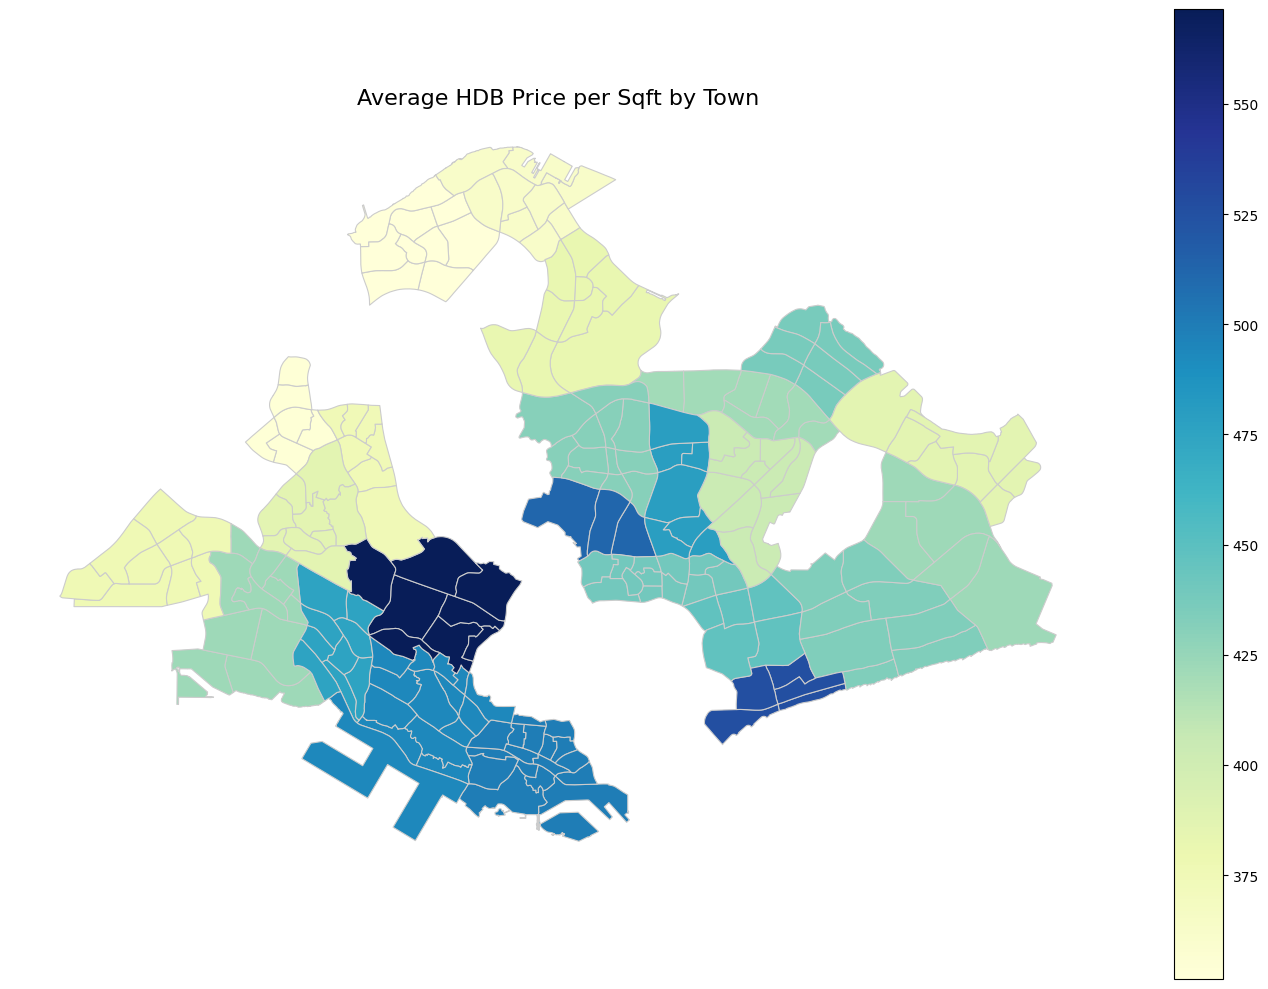

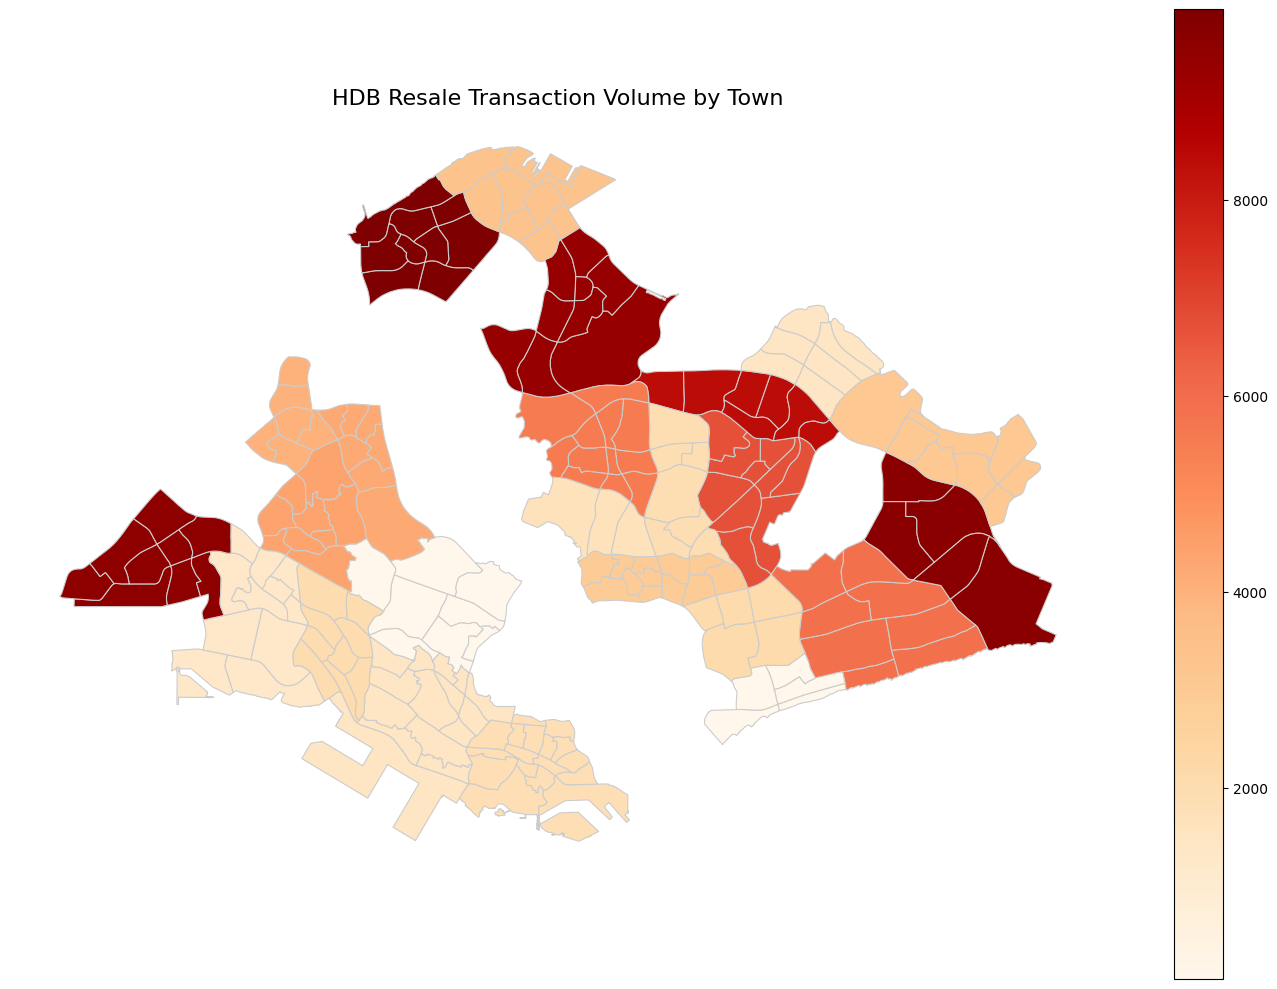

In [33]:
# 14. As an agent, I want to see a map showing the distribution of HDB resale flats across Singapore, to visualize potential sales opportunities.
# 22. As an agent, I want to Identify location-based trends to guide my sales strategy

# average price per sqft grouped by towns
hdb.groupby('town')['price_per_sqft'].mean().plot(kind = 'bar')

# Read GeoJSON
gdf = gpd.read_file('datasets/Master Plan 2019 Subzone Boundary (No Sea) (GEOJSON).geojson')
# Extract town names from HTML in Description column
def extract_towns(html_str):
    match = re.search(r'<th>PLN_AREA_N</th>\s*<td>(.*?)</td>', html_str)
    if match:
        return match.group(1).strip().upper()
    return None
gdf['PLN_AREA_N'] = gdf['Description'].apply(extract_towns)
# Prep HDB data
hdb['town'] = hdb['town'].str.upper().str.strip()
# Group by town
avg_price = hdb.groupby('town')['price_per_sqft'].mean().reset_index()
transaction_count = hdb.groupby('town').size().reset_index(name='transaction_count')
# Merge both
town_stats = avg_price.merge(transaction_count, on='town')
town_stats.columns = ['PLN_AREA_N', 'avg_price_per_sqft', 'transaction_count']
# Merge with geodata
merged = gdf.merge(town_stats, on='PLN_AREA_N', how='left')
# PLOT 1: Average price per sqft
fig, ax = plt.subplots(1, 1, figsize=(14, 10))
merged.plot(column='avg_price_per_sqft',
            cmap='YlGnBu',
            linewidth=0.8,
            ax=ax,
            edgecolor='0.8',
            legend=True)
# Add title and clean-up
plt.title("Average HDB Price per Sqft by Town", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()
# PLOT 2: Average transaction volume by location
fig, ax = plt.subplots(1, 1, figsize=(14, 10))
merged.plot(column='transaction_count',
            cmap='OrRd',
            linewidth=0.8,
            ax=ax,
            edgecolor='0.8',
            legend=True)
plt.title("HDB Resale Transaction Volume by Town", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

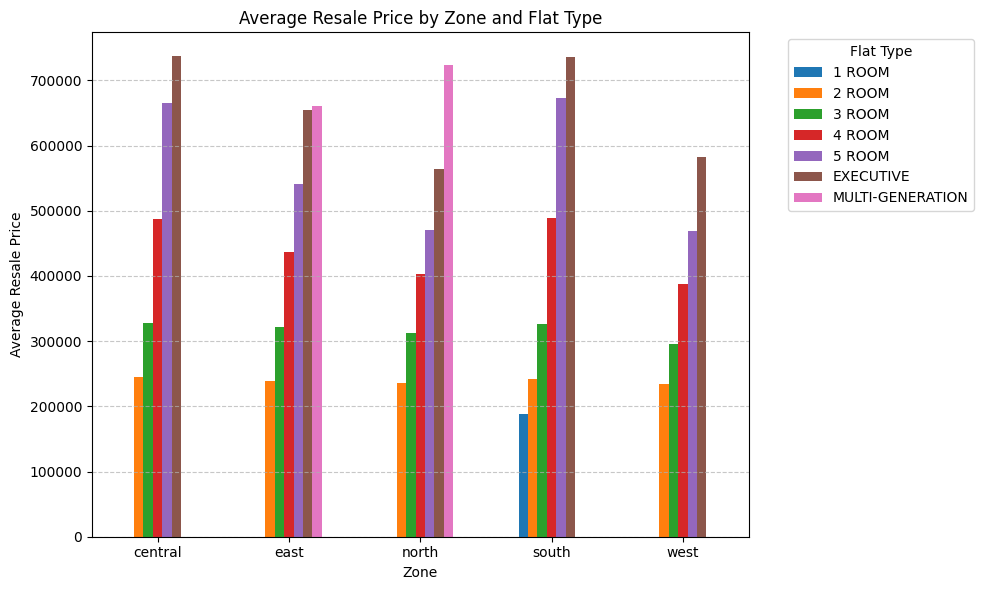

In [34]:
# Group by flat_type and zone, then calculate mean resale price
grouped = hdb.groupby(['zone', 'flat_type'])['resale_price'].mean().reset_index()

# Pivot the table: zones as index, flat_type as columns
pivoted = grouped.pivot(index='zone', columns='flat_type', values='resale_price')

# Plot the clustered bar chart
pivoted.plot(kind='bar', figsize=(10, 6))

# Add labels and formatting
plt.title('Average Resale Price by Zone and Flat Type')
plt.ylabel('Average Resale Price')
plt.xlabel('Zone')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Flat Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()

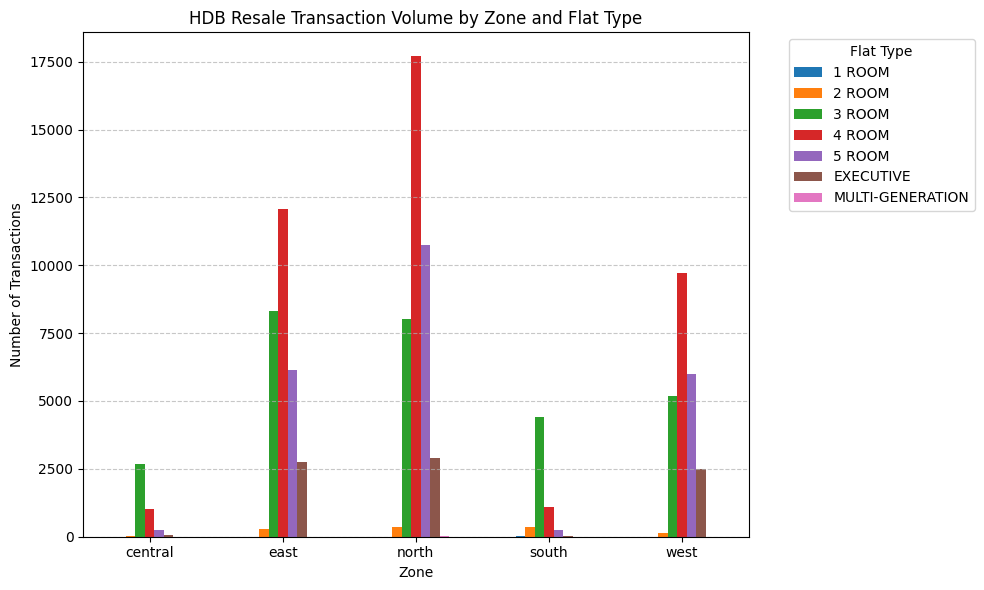

In [35]:
# Group by zone and flat type, and count number of transactions
grouped = hdb.groupby(['zone', 'flat_type']).size().reset_index(name='transaction_count')

# Pivot table: zones as index, flat types as columns
pivoted = grouped.pivot(index='zone', columns='flat_type', values='transaction_count').fillna(0)

# Plot clustered bar chart
pivoted.plot(kind='bar', figsize=(10, 6))

# Add labels and formatting
plt.title('HDB Resale Transaction Volume by Zone and Flat Type')
plt.ylabel('Number of Transactions')
plt.xlabel('Zone')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Flat Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()

# Selecting numerical features with correlation

In [36]:
## NOTE Use of ['resale_price'] here to get correlation only with respect to itself 
correlations = hdb.corr(numeric_only=True)['resale_price']

correlations.head()

id                0.648644
floor_area_sqm    0.783330
resale_price      1.000000
Tranc_Year       -0.098815
Tranc_Month      -0.006291
Name: resale_price, dtype: float64

In [37]:
correlations.sort_values(ascending=False)

resale_price                 1.000000
floor_area_sqm               0.783330
id                           0.648644
exec_sold                    0.460839
price_per_sqft               0.345757
5room_sold                   0.304474
max_floor_lvl                0.232971
Longitude                    0.166246
Hawker_Nearest_Distance      0.153186
mrt_interchange              0.145481
mid_storey                   0.144064
bus_interchange              0.092710
Mature Estates               0.038470
multigen_sold                0.037014
pri_sch_affiliation          0.012924
other_room_rental            0.001844
bus_stop_nearest_distance   -0.004566
Tranc_Month                 -0.006291
studio_apartment_sold       -0.010021
Latitude                    -0.016500
cutoff_point                -0.019185
sec_sch_nearest_dist        -0.026695
1room_sold                  -0.043749
4room_sold                  -0.045435
pri_sch_nearest_distance    -0.046434
1room_rental                -0.047753
hawker_food_

# Numerical features/columns for modelling: 

floor_area_sqm               (0.783330)

exec_sold                    (0.460839)

5room_sold                   (0.304474)

max_floor_lvl                (0.232971)

hdb_age                      (-0.357272)

total_dwelling_units         (-0.423408)

3room_sold                   (-0.486963)

# Now selecting categorical features with value_counts

In [38]:
# Use value_counts to evaluate categorical columns: 

zonevc = hdb['zone'].value_counts() # Decision to use this over the others as it fits with model better 

townvc = hdb['town'].value_counts()
flat_typevc = hdb['flat_type'].value_counts()
storey_rangevc = hdb['storey_range'].value_counts()

print(zonevc, townvc, flat_typevc, storey_rangevc)

zone
north      39724
east       29555
west       23518
south       6203
central     4033
Name: count, dtype: int64 town
WOODLANDS          9949
TAMPINES           9647
JURONG WEST        9570
YISHUN             9360
SENGKANG           8391
HOUGANG            6726
BEDOK              5915
ANG MO KIO         5552
BUKIT BATOK        4405
BUKIT PANJANG      4228
CHOA CHU KANG      4016
SEMBAWANG          3399
PASIR RIS          3129
TOA PAYOH          2917
GEYLANG            2098
CLEMENTI           2024
KALLANG/WHAMPOA    2009
SERANGOON          1938
BUKIT MERAH        1825
BISHAN             1661
QUEENSTOWN         1461
PUNGGOL            1412
JURONG EAST        1254
MARINE PARADE       102
CENTRAL AREA         71
BUKIT TIMAH          45
Name: count, dtype: int64 flat_type
4 ROOM              41607
3 ROOM              28605
5 ROOM              23367
EXECUTIVE            8238
2 ROOM               1213
1 ROOM                 45
MULTI-GENERATION       29
Name: count, dtype: int64 storey_rang

# Categorical features/columns for modelling: 

zone

---

# One-hot encoding

In [39]:
# drop_first argument to save coding lines 
hdb = pd.get_dummies(hdb, columns=['zone'], drop_first=True)

In [40]:
hdb.head()

,id,Tranc_YearMonth,town,flat_type,street_name,storey_range,floor_area_sqm,flat_model,resale_price,Tranc_Year,...,bus_stop_nearest_distance,pri_sch_nearest_distance,pri_sch_affiliation,sec_sch_nearest_dist,cutoff_point,Mature Estates,zone_east,zone_north,zone_south,zone_west
0,122598,2012-07-01,BISHAN,5 ROOM,BISHAN ST 13,07 TO 09,130,Improved,665000.0,2012,...,58.207761,415.607357,1,447.894399,232,1.0,False,True,False,False
1,86070,2012-04-01,BISHAN,4 ROOM,BISHAN ST 22,01 TO 05,103,Model A,550000.0,2012,...,43.396521,389.515528,1,389.515528,253,1.0,False,True,False,False
2,26610,2013-01-01,GEYLANG,3 ROOM,ALJUNIED CRES,07 TO 09,65,Improved,335000.0,2013,...,229.680469,594.128568,1,608.838174,224,1.0,True,False,False,False
3,173300,2018-05-01,HOUGANG,5 ROOM,HOUGANG AVE 8,07 TO 09,120,Improved,433000.0,2018,...,46.567429,331.669318,0,294.826501,224,0.0,True,False,False,False
4,103385,2014-06-01,SENGKANG,5 ROOM,ANCHORVALE RD,10 TO 12,110,Improved,490000.0,2014,...,89.350913,94.340507,0,458.532781,243,0.0,False,True,False,False


---

# <font color='blue'> Modelling

> # Linear Regression

In [41]:
feature_cols = [
    'floor_area_sqm', 'exec_sold', '5room_sold', 'max_floor_lvl', 'hdb_age', 'total_dwelling_units', '3room_sold',
    'zone_east', 'zone_north', 'zone_south', 'zone_west']

X = hdb[feature_cols]
y = hdb['resale_price']

lr = LinearRegression()
lr.fit(X,y)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [42]:
def train_test_rmse(hdb, feature_cols):
    X = hdb[feature_cols]
    y = hdb.resale_price
    X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=123)
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    y_pred = linreg.predict(X_test)
    return np.sqrt(metrics.mean_squared_error(y_test, y_pred)), r2_score(y_test, y_pred)

print(train_test_rmse(hdb, feature_cols))

(np.float64(61065.72858667722), 0.692333562297705)


> # Random Forest

In [43]:
# Define X and y
X = hdb[feature_cols]
y = hdb['resale_price']
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
# Build and fit the model
rf_model = RandomForestRegressor(random_state=123)
rf_model.fit(X_train, y_train)
# Predict and evaluate
y_pred = rf_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared Score: {r2:.4f}")

Root Mean Squared Error (RMSE): 40017.31
Mean Squared Error: 1601385341.92
R-squared Score: 0.8679


> # <font color='blue'> **Random Forest model has better RMSE & R-squared.**

| | Root Mean Squared Error | R-Squared Score |
| --- | ---- | ---- |
| Linear Regression | 61065 | 0.69 |
| Random Forest Regressor | **40017** | **0.87** |

# Random Forest Features Importances 

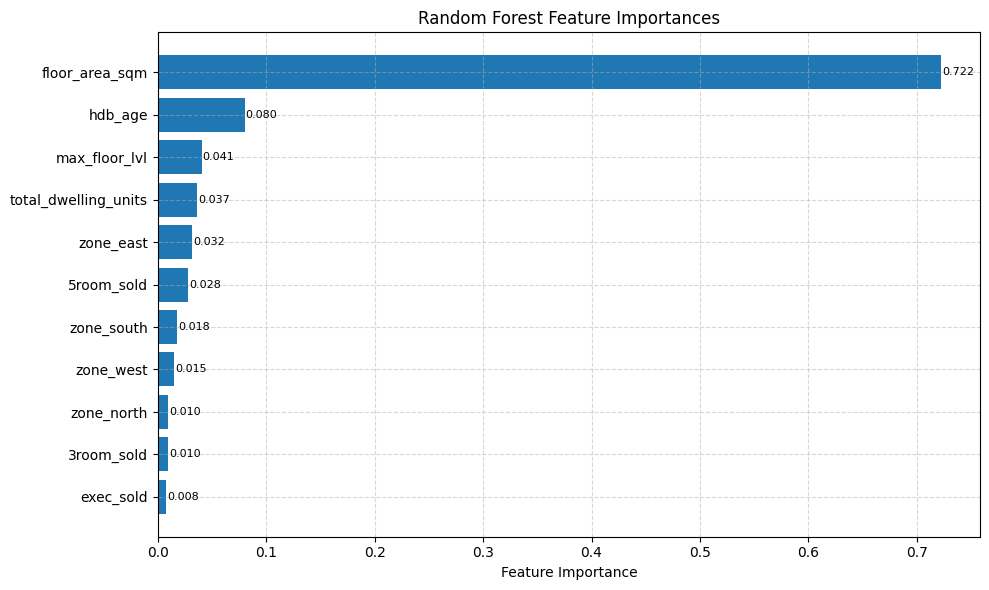

In [44]:
# Get feature importances from the trained model
importances = rf_model.feature_importances_
feature_names = X.columns
# Create a DataFrame for better visualisation
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
# Plot it
plt.figure(figsize=(10, 6))
bars = plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importances')
plt.gca().invert_yaxis()  # Highest at the top
plt.grid(True, linestyle='--', alpha=0.5)
# Add value labels to the bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
             f"{width:.3f}", va='center', fontsize=8)
plt.tight_layout()
plt.show()

---

In [45]:
# Using joblib library: Save the model to a file. 
# First part of process for adding predictions column 'Predicted_Price' for test.csv. 
# Also for bug-testing streamlit setup. 

joblib.dump(rf_model, 'random_forest_model.pkl')

['random_forest_model.pkl']

---